In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import numpy as np
from PIL import Image
# torch imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

In [2]:
class FairFaceDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.copy()
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        img_path = os.path.join(self.image_dir, row['file'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        labels = torch.tensor([
            int(row['age_label']),
            int(row['gender_label']),
            int(row['race_label'])
        ], dtype=torch.long)

        return image, labels


In [3]:
# High level feature extractor network (Adopted VGG type structure)
class highLevelNN(nn.Module):
    def __init__(self):
        super(highLevelNN, self).__init__()
        self.CNN = nn.Sequential(
            # first batch (32)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # second batch (64)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # Third Batch (128)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        out = self.CNN(x)

        return out

# Low level feature extraction module
class lowLevelNN(nn.Module):
    def __init__(self, num_out):
        super(lowLevelNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        # Updated shape after flattening: 512 * 4 * 4 = 8192
        self.fc1 = nn.Linear(in_features=8192, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=num_out)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=2, padding=1))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=3, stride=2, padding=1))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x


class TridentNN(nn.Module):
    def __init__(self, num_age, num_gen, num_eth):
        super(TridentNN, self).__init__()
        # Construct the high level neural network
        self.CNN = highLevelNN()
        # Construct the low level neural networks
        self.ageNN = lowLevelNN(num_out=num_age)
        self.genNN = lowLevelNN(num_out=num_gen)
        self.ethNN = lowLevelNN(num_out=num_eth)

    def forward(self, x):
        x = self.CNN(x)
        age = self.ageNN(x)
        gen = self.genNN(x)
        eth = self.ethNN(x)

        return age, gen, eth

In [4]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [5]:
'''
    Function to test the trained model

    Inputs:
      - testloader : PyTorch DataLoader containing the test dataset
      - modle : Trained NeuralNetwork

    Outputs:
      - Prints out test accuracy for gender and ethnicity and loss for age
'''
def test(testloader, model):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  size = len(testloader.dataset)
  # put the moel in evaluation mode so we aren't storing anything in the graph
  model.eval()

  age_acc, gen_acc, eth_acc = 0, 0, 0

  with torch.no_grad():
      for X, y in testloader:
          X = X.to(device)
          age, gen, eth = y[:,0].to(device), y[:,1].to(device), y[:,2].to(device)
          pred = model(X)

          age_acc += (pred[0].argmax(1) == age).type(torch.float).sum().item()
          gen_acc += (pred[1].argmax(1) == gen).type(torch.float).sum().item()
          eth_acc += (pred[2].argmax(1) == eth).type(torch.float).sum().item()

  age_acc /= size
  gen_acc /= size
  eth_acc /= size

  print(f"Age Accuracy : {age_acc*100}%,     Gender Accuracy : {gen_acc*100},    Ethnicity Accuracy : {eth_acc*100}\n")

In [6]:
# Set paths
fairface_folder_path = "/kaggle/input/fairface/FairFace"
train_csv_path = os.path.join(fairface_folder_path, "train_labels.csv")
val_csv_path = os.path.join(fairface_folder_path, "val_labels.csv")

# Read CSVs
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)

# Define age group mapping
age_groups = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70']
age_mapping = {k: v for v, k in enumerate(age_groups)}

# Map labels for age, gender, and race
for df in [train_df, val_df]:
    df['age_label'] = df['age'].map(age_mapping)
    df['gender_label'] = df['gender'].map({'Male': 0, 'Female': 1})
    df['race_label'] = df['race'].map({
        'White': 0, 'Black': 1, 'East Asian': 2, 'Indian': 3, 'Latino_Hispanic': 4,
        'Middle Eastern': 5, 'Southeast Asian': 6
    })

# Add full file paths
train_df['file_path'] = train_df['file'].apply(lambda x: os.path.join(fairface_folder_path, x))
val_df['file_path'] = val_df['file'].apply(lambda x: os.path.join(fairface_folder_path, x))

# Split training data into train and test (80/20)
val_df_final, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

# Class counts (optional, useful for configuring model outputs)
class_nums = {
    'age_num': len(train_df['age_label'].unique()),
    'eth_num': len(train_df['race_label'].unique()),
    'gen_num': len(train_df['gender_label'].unique())
}

# Define preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Initialize datasets
train_set = FairFaceDataset(train_df, image_dir=fairface_folder_path, transform=transform)
val_set = FairFaceDataset(val_df_final, image_dir=os.path.join(fairface_folder_path), transform=transform)
test_set = FairFaceDataset(test_df, image_dir=fairface_folder_path, transform=transform)

# Initialize data loaders
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)
valloader = DataLoader(val_set, batch_size=128, shuffle=False)
testloader = DataLoader(test_set, batch_size=128, shuffle=False)

# Print dataset sizes
print(f"Number of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(val_df_final)}")
print(f"Number of test samples: {len(test_df)}")

# Sanity check
for X, y in trainloader:
    print(f'Shape of training X: {X.shape}')
    print(f'Shape of y: {y.shape}')
    break

Number of training samples: 86744
Number of validation samples: 5477
Number of test samples: 5477
Shape of training X: torch.Size([64, 3, 128, 128])
Shape of y: torch.Size([64, 3])


In [7]:
# Configure the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Define the list of hyperparameters
hyperparameters = {'learning_rate':0.001, 'epochs':30}

# Initialize the TridentNN model and put on device
model = TridentNN(class_nums['age_num'], class_nums['gen_num'], class_nums['eth_num'])
model.to(device)

cuda


TridentNN(
  (CNN): highLevelNN(
    (CNN): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): ReLU()
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (9): ReLU()
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (14): ReLU()
    )
  )
  (ageNN): lowLevelNN(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [8]:
'''
  Functions to load and save a PyTorch model
'''
def save_checkpoint(state, epoch):
  print("Saving Checkpoint")
  filename = "tridentNN_epoch"+str(epoch)+".pth.tar"
  torch.save(state,filename)

def load_checkpoint(checkpoint):
  print("Loading Checkpoint")
  model.load_state_dict(checkpoint['state_dict'])
  opt.load_state_dict(checkpoint['optimizer'])


In [9]:
def evaluate_val_loss(model, valloader, age_loss, gen_loss, eth_loss, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in valloader:
            X_val = X_val.to(device)
            age_val, gen_val, eth_val = y_val[:,0].to(device), y_val[:,1].to(device), y_val[:,2].to(device)
            pred_val = model(X_val)
            loss = age_loss(pred_val[0], age_val) + gen_loss(pred_val[1], gen_val) + eth_loss(pred_val[2], eth_val)
            val_loss += loss.item()
    return val_loss / len(valloader)


In [10]:
def get_flattened_size(model, input_shape=(3, 124, 124)):
    with torch.no_grad():
        x = torch.zeros(1, *input_shape)
        x = model.CNN(x)
        return x.view(1, -1).size(1)


In [12]:
'''
train the model
'''
# Load hyperparameters
learning_rate = hyperparameters['learning_rate']
num_epoch = hyperparameters['epochs']

# Define loss functions
age_loss = nn.CrossEntropyLoss()
gen_loss = nn.CrossEntropyLoss()
eth_loss = nn.CrossEntropyLoss()

# Define optimizer
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=2, verbose=True)

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

# Init best model saving
best_model_state = None
best_epoch = 0

train_losses = []
val_losses = []

# Train the model
for epoch in range(num_epoch):
  model.train()  # Ensure training mode
  # Construct tqdm loop to keep track of training
  loop = tqdm(enumerate(trainloader), total=len(trainloader), position=0, leave=True)
  age_correct, gen_correct, eth_correct, total = 0,0,0,0

  running_loss = 0.0

  # save the model every 5 epochs
  if epoch % 5 == 0:
    checkpoint = {'state_dict' : model.state_dict(), 'optimizer' : opt.state_dict(),
                  'age_loss' : age_loss, 'gen_loss' : gen_loss, 'eth_loss' : eth_loss}
    save_checkpoint(checkpoint, epoch)

  # Loop through dataLoader
  for _, (X,y) in loop:
    # Unpack y to get true age, eth, and gen values
    # Have to do some special changes to age label to make it compatible with NN output and Loss function
    #age, gen, eth = y[:,0].resize_(len(y[:,0]),1).float().to(device), y[:,1].to(device), y[:,2].to(device)
    age, gen, eth = y[:,0].to(device), y[:,1].to(device), y[:,2].to(device)
    X = X.to(device)
    pred = model(X)          # Forward pass
    loss = age_loss(pred[0],age) + gen_loss(pred[1],gen) + eth_loss(pred[2],eth)   # Loss calculation

    # Backpropagation
    opt.zero_grad()          # Zero the gradient
    loss.backward()          # Calculate updates

    # Gradient Descent
    opt.step()               # Apply updates

    # Update num correct and total
    age_correct += (pred[0].argmax(1) == age).type(torch.float).sum().item()
    gen_correct += (pred[1].argmax(1) == gen).type(torch.float).sum().item()
    eth_correct += (pred[2].argmax(1) == eth).type(torch.float).sum().item()

    total += len(y)

    running_loss += loss.item()

    # Update progress bar
    loop.set_description(f"Epoch [{epoch+1}/{num_epoch}]")
    loop.set_postfix(loss = loss.item())

  # Update epoch accuracy
  gen_acc, eth_acc, age_acc = gen_correct/total, eth_correct/total, age_correct/total

  # print out accuracy and loss for epoch
  print(f'Epoch : {epoch+1}/{num_epoch},    Age Accuracy : {age_acc*100},    Gender Accuracy : {gen_acc*100},    Ethnicity Accuracy : {eth_acc*100}\n')

  epoch_train_loss = running_loss / len(trainloader)

  # Validation loss
  val_loss = evaluate_val_loss(model, valloader, age_loss, gen_loss, eth_loss, device)
  print(f'Train loss: {epoch_train_loss:.4f} Validation loss: {val_loss:.4f}')

  scheduler.step(val_loss)

  for param_group in opt.param_groups:
    print(f"Current learning rate: {param_group['lr']}")

  train_losses.append(epoch_train_loss)
  val_losses.append(val_loss)

  # Early stopping
  if early_stopping.best_loss is None or val_loss < early_stopping.best_loss - early_stopping.min_delta:
      best_model_state = model.state_dict()
      best_epoch = epoch + 1

  early_stopping(val_loss)
  if early_stopping.early_stop:
      print(f"Early stopping activated after {epoch+1}. epoch. Best epoch: {best_epoch}")
      torch.save(best_model_state, '/kaggle/working/best_model.pt')
      break

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/1356 [00:00<?, ?it/s]

Saving Checkpoint


Epoch [1/30]: 100%|██████████| 1356/1356 [07:06<00:00,  3.18it/s, loss=3.37]


Epoch : 1/30,    Age Accuracy : 34.37817024808632,    Gender Accuracy : 70.51669279719634,    Ethnicity Accuracy : 32.61897076454856

Train loss: 3.9132 Validation loss: 3.2056
Current learning rate: 0.001


Epoch [2/30]: 100%|██████████| 1356/1356 [06:09<00:00,  3.67it/s, loss=3]   


Epoch : 2/30,    Age Accuracy : 45.48210827261828,    Gender Accuracy : 83.506640228719,    Ethnicity Accuracy : 48.736512035414556

Train loss: 2.9791 Validation loss: 2.9338
Current learning rate: 0.001


Epoch [3/30]: 100%|██████████| 1356/1356 [05:57<00:00,  3.79it/s, loss=2.33]


Epoch : 3/30,    Age Accuracy : 49.36825601770728,    Gender Accuracy : 86.46246426265793,    Ethnicity Accuracy : 53.94033016692797

Train loss: 2.6797 Validation loss: 2.6993
Current learning rate: 0.001


Epoch [4/30]: 100%|██████████| 1356/1356 [06:08<00:00,  3.68it/s, loss=2.37]


Epoch : 4/30,    Age Accuracy : 51.61163884533801,    Gender Accuracy : 88.23088628608319,    Ethnicity Accuracy : 57.170524762519605

Train loss: 2.5014 Validation loss: 2.6946
Current learning rate: 0.001


Epoch [5/30]: 100%|██████████| 1356/1356 [06:09<00:00,  3.67it/s, loss=2.35]


Epoch : 5/30,    Age Accuracy : 53.68325186756433,    Gender Accuracy : 89.60158627686064,    Ethnicity Accuracy : 59.590288665498484

Train loss: 2.3649 Validation loss: 2.6291
Current learning rate: 0.001


  0%|          | 0/1356 [00:00<?, ?it/s]

Saving Checkpoint


Epoch [6/30]: 100%|██████████| 1356/1356 [06:16<00:00,  3.60it/s, loss=2.15]


Epoch : 6/30,    Age Accuracy : 55.106981462694826,    Gender Accuracy : 90.62644102185742,    Ethnicity Accuracy : 62.0146638384211

Train loss: 2.2464 Validation loss: 2.6766
Current learning rate: 0.001


Epoch [7/30]: 100%|██████████| 1356/1356 [06:25<00:00,  3.51it/s, loss=2.07]


Epoch : 7/30,    Age Accuracy : 56.92728027298718,    Gender Accuracy : 91.56483445540901,    Ethnicity Accuracy : 64.21769805404408

Train loss: 2.1294 Validation loss: 2.6504
Current learning rate: 0.001


Epoch [8/30]: 100%|██████████| 1356/1356 [06:11<00:00,  3.65it/s, loss=2.75]


Epoch : 8/30,    Age Accuracy : 58.36253804297704,    Gender Accuracy : 92.54588213594023,    Ethnicity Accuracy : 66.1694180577331

Train loss: 2.0202 Validation loss: 2.7030
Current learning rate: 0.0005


Epoch [9/30]: 100%|██████████| 1356/1356 [06:00<00:00,  3.76it/s, loss=1.58]


Epoch : 9/30,    Age Accuracy : 63.79691967167758,    Gender Accuracy : 95.10859540717513,    Ethnicity Accuracy : 72.61712625657107

Train loss: 1.6768 Validation loss: 2.8356
Current learning rate: 0.0005


Epoch [10/30]: 100%|██████████| 1356/1356 [06:02<00:00,  3.74it/s, loss=1.54]


Epoch : 10/30,    Age Accuracy : 66.79655077008209,    Gender Accuracy : 96.26487134556857,    Ethnicity Accuracy : 75.6824679516739

Train loss: 1.5001 Validation loss: 3.0988
Current learning rate: 0.0005
Early stopping activated after 10. epoch. Best epoch: 5


In [13]:
# Load the best model
model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))
model.to(device)
model.eval()


/tmp/ipykernel_189/1260066757.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))


TridentNN(
  (CNN): highLevelNN(
    (CNN): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): ReLU()
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (9): ReLU()
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (14): ReLU()
    )
  )
  (ageNN): lowLevelNN(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

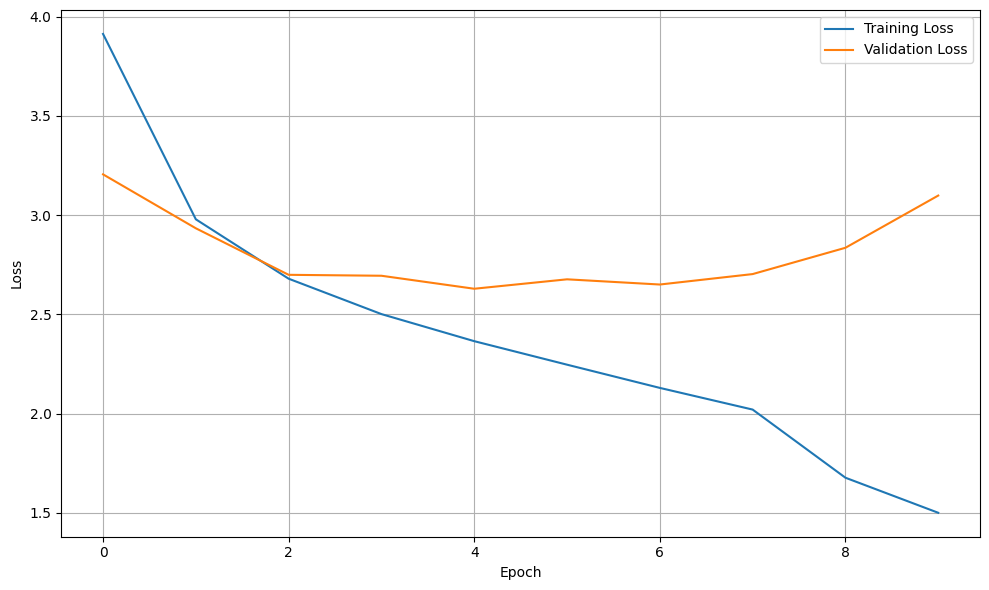

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_curve.png')
plt.show()


In [15]:
test(testloader, model)

Age Accuracy : 50.94029578236261%,     Gender Accuracy : 87.47489501551945,    Ethnicity Accuracy : 57.56801168522914



In [24]:
# Storing the predictions

all_true_age = []
all_pred_age = []

all_true_gender = []
all_pred_gender = []

all_true_ethnicity = []
all_pred_ethnicity = []

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        age_output, gender_output, ethnicity_output = outputs

        _, age_preds = torch.max(age_output, 1)
        _, gender_preds = torch.max(gender_output, 1)
        _, ethnicity_preds = torch.max(ethnicity_output, 1)

        all_true_age.append(labels[:, 0].cpu())
        all_pred_age.append(age_preds.cpu())

        all_true_gender.append(labels[:, 1].cpu())
        all_pred_gender.append(gender_preds.cpu())

        all_true_ethnicity.append(labels[:, 2].cpu())
        all_pred_ethnicity.append(ethnicity_preds.cpu())

true_age = torch.cat(all_true_age).numpy()
pred_age = torch.cat(all_pred_age).numpy()

true_gender = torch.cat(all_true_gender).numpy()
pred_gender = torch.cat(all_pred_gender).numpy()

true_ethnicity = torch.cat(all_true_ethnicity).numpy()
pred_ethnicity = torch.cat(all_pred_ethnicity).numpy()


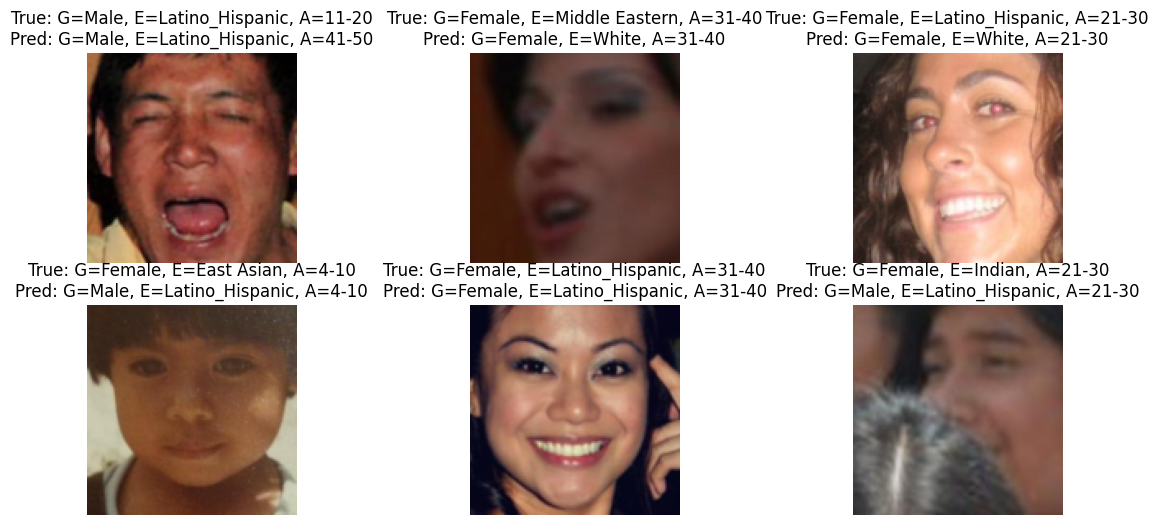

In [22]:
def denormalize(img_tensor):
    img_tensor = img_tensor * 0.5 + 0.5
    return img_tensor


model.eval()

# Visualize the predictions
images, labels = next(iter(testloader))
images = images.to(device)
labels = labels.to(device)

age_labels = labels[:, 0]
gender_labels = labels[:, 1]
ethnicity_labels = labels[:, 2]

with torch.no_grad():
    outputs = model(images)
    age_preds = torch.argmax(outputs[0], dim=1)
    gender_preds = torch.argmax(outputs[1], dim=1)
    ethnicity_preds = torch.argmax(outputs[2], dim=1)

class_names = {
    'gender': ['Male', 'Female'],
    'ethnicity': ['White', 'Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian'],
    'age': ['0-3', '4-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '70+']
}

num_images = 6
fig, axes = plt.subplots(2, 3, figsize=(14, 6))

for i in range(num_images):
    img = denormalize(images[i].cpu())
    img = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    img = img.clip(0, 1)

    true_gender = class_names['gender'][gender_labels[i].item()]
    true_ethnicity = class_names['ethnicity'][ethnicity_labels[i].item()]
    true_age = class_names['age'][age_labels[i].item()]

    pred_gender = class_names['gender'][gender_preds[i].item()]
    pred_ethnicity = class_names['ethnicity'][ethnicity_preds[i].item()]
    pred_age = class_names['age'][age_preds[i].item()]

    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.set_title(f"True: G={true_gender}, E={true_ethnicity}, A={true_age}\n"
                 f"Pred: G={pred_gender}, E={pred_ethnicity}, A={pred_age}")
    ax.axis('off')


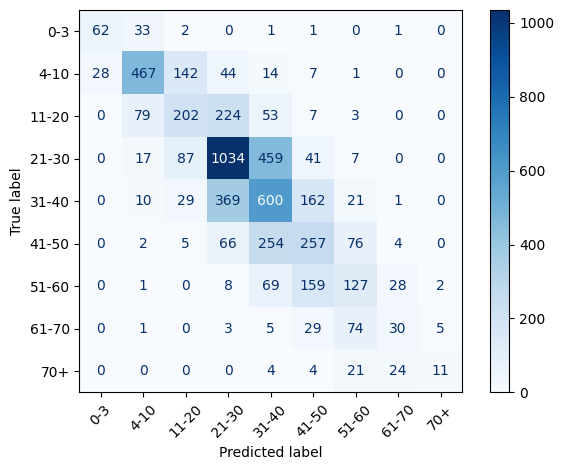

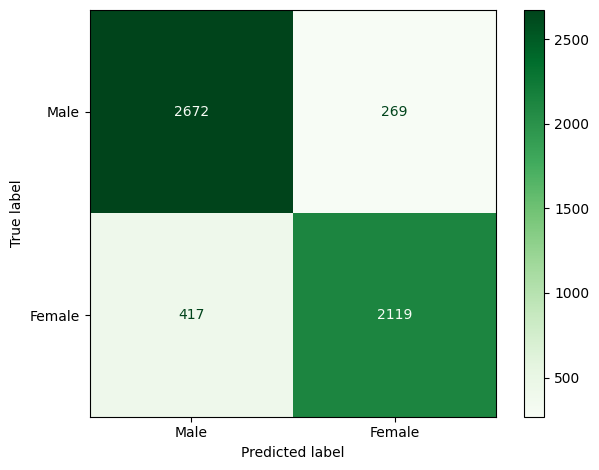

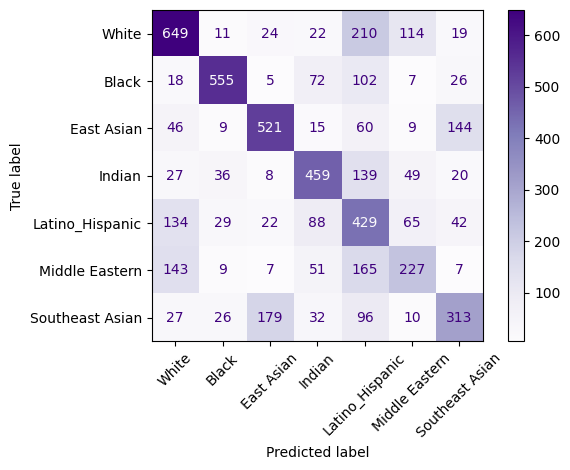

In [25]:
# Confusion matrix for age
cm_age = confusion_matrix(true_age, pred_age)
disp_age = ConfusionMatrixDisplay(confusion_matrix=cm_age, display_labels=class_names['age'])
disp_age.plot(cmap='Blues', xticks_rotation=45)
plt.tight_layout()
plt.show()

# Confusion matrix for gender
cm_gender = confusion_matrix(true_gender, pred_gender)
disp_gender = ConfusionMatrixDisplay(confusion_matrix=cm_gender, display_labels=class_names['gender'])
disp_gender.plot(cmap='Greens')
plt.tight_layout()
plt.show()

# Confusion matrix for ethnicity
cm_ethnicity = confusion_matrix(true_ethnicity, pred_ethnicity)
disp_ethnicity = ConfusionMatrixDisplay(confusion_matrix=cm_ethnicity, display_labels=class_names['ethnicity'])
disp_ethnicity.plot(cmap='Purples', xticks_rotation=45)
plt.tight_layout()
plt.show()